In [2]:
import pandas as pd
import numpy as np
import shap
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams

In [3]:
# Import data
from os.path import dirname, join
from pathlib import Path
ROOT_DIR = dirname(os.path.abspath('ARCH7211-SPRING2021')) # This is your Project Root
data_PATH = join(ROOT_DIR,"data","room_info.csv")  # requires `import os`

# input data
data_raw = pd.read_csv(r'C:\Users\milad\Documents\GitHub\arch7211-spring2021\data\room_info.csv')

In [4]:
#Cleaning data and feature engineering
exclusion = ["Undefined","UserDefined","Other","Elevated"]
merge = {
    "Sauna": "Bath",
    "Den":"LivingRoom",
    "Alcove":"LivingRoom",
    "Library": "Room",
    "RecreationRoom":"Room",
    "DressingRoom":'Closet',
    "Attic" : "Storage",
    "Office" : "Room",
    "TechnicalRoom":"Utility",
    "DraughtLobby" : "Entry",
    "Hall" : "Entry",
    "Basement" : "Storage"
}

data_raw["type_cleaned"] = data_raw["type"].apply(lambda x: merge.get(x,x))
data_raw["exclude"] = ~data_raw["type"].isin(exclusion)

In [5]:
data_cleaned = data_raw[~data_raw["type"].isin(exclusion)]

In [6]:
data_cleaned.groupby("type_cleaned",as_index=False).count().sort_values("path")

,type_cleaned,path,type,classes,floor_index,num_sides,area,proportion_floor_area,perimeter,compactness,...,contains_Sink,contains_SpaceForAppliance,contains_Stove,contains_Toilet,contains_TumbleDryer,contains_Urinal,contains_WallCabinet,contains_WashingMachine,contains_WaterTap,exclude
2,CarPort,279,279,279,279,279,279,279,279,279,...,279,279,279,279,279,279,279,279,279,279
6,Garage,414,414,414,414,414,414,414,414,414,...,414,414,414,414,414,414,414,414,414,414
4,Dining,954,954,954,954,954,954,954,954,954,...,954,954,954,954,954,954,954,954,954,954
12,Utility,1489,1489,1489,1489,1489,1489,1489,1489,1489,...,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489
11,Storage,1953,1953,1953,1953,1953,1953,1953,1953,1953,...,1953,1953,1953,1953,1953,1953,1953,1953,1953,1953
10,Room,2116,2116,2116,2116,2116,2116,2116,2116,2116,...,2116,2116,2116,2116,2116,2116,2116,2116,2116,2116
3,Closet,3041,3041,3041,3041,3041,3041,3041,3041,3041,...,3041,3041,3041,3041,3041,3041,3041,3041,3041,3041
8,LivingRoom,4428,4428,4428,4428,4428,4428,4428,4428,4428,...,4428,4428,4428,4428,4428,4428,4428,4428,4428,4428
7,Kitchen,4548,4548,4548,4548,4548,4548,4548,4548,4548,...,4548,4548,4548,4548,4548,4548,4548,4548,4548,4548
5,Entry,6050,6050,6050,6050,6050,6050,6050,6050,6050,...,6050,6050,6050,6050,6050,6050,6050,6050,6050,6050


In [7]:
# Dividing the raw dataset into three sub categories (tier A,B,C)
# Tiers are: fur = furniture related features, con= space connectivity features, spc = space characteristics features
tier_fur = ['type_cleaned']
tier_spc = []
tier_con = ['type_cleaned']
for col in data_cleaned.columns:
    if 'contains_' in col:
        tier_fur.append(col)
    elif '_to_' in col:
        tier_con.append(col)
    else:
        tier_spc.append(col)
col_select = {
    'tierA' : tier_fur,
    'tierB' : tier_con,
    'tierC' : tier_spc
            } 

In [8]:
#Creating sub-datasets for each tier : tier1) furniture characteristics tier2) fur + connectivity tier 3) whole dataset
data_tier1a = pd.DataFrame(data_cleaned[col_select['tierA']])
data_tier1b = pd.DataFrame(data_cleaned[col_select['tierB']])
data_tier1c = pd.DataFrame(data_cleaned[col_select['tierC']])
data_tier2 = data_tier1c.copy()
data_tier2[col_select['tierB']] = data_tier1b
# quick view of the dataset grouped by type


In [10]:
data_tier2.columns

Index(['path', 'type', 'classes', 'floor_index', 'num_sides', 'area',
       'proportion_floor_area', 'perimeter', 'compactness',
       'num_adjacent_walls', 'proportion_exterior_walls',
       'num_adjacent_railings', 'num_adjacent_rooms', 'num_connected_rooms',
       'num_doors', 'num_windows', 'num_fixtures', 'open_to', 'door_to',
       'contains', 'type_cleaned', 'exclude', 'open_to_Alcove',
       'door_to_Alcove', 'open_to_Attic', 'door_to_Attic', 'open_to_Basement',
       'door_to_Basement', 'open_to_Bath', 'door_to_Bath', 'open_to_Bedroom',
       'door_to_Bedroom', 'open_to_CarPort', 'door_to_CarPort',
       'open_to_Closet', 'door_to_Closet', 'open_to_Den', 'door_to_Den',
       'open_to_Dining', 'door_to_Dining', 'open_to_DraughtLobby',
       'door_to_DraughtLobby', 'open_to_DressingRoom', 'door_to_DressingRoom',
       'open_to_Elevated', 'door_to_Elevated', 'open_to_Entry',
       'door_to_Entry', 'open_to_Garage', 'door_to_Garage', 'open_to_Hall',
       'door_to_Ha

In [ ]:
#Clean input data from the target data
# define features and predictions
X = data_tier1a.drop([x for x in['path','type','classes','open_to','door_to','contains','type_cleaned','exclude'] if x in data_tier1a.columns], axis =1)
y = data_tier1a['type_cleaned']
#Split the data into training data, and test data 
X_train , X_test, y_train, y_test = train_test_split(X,y, test_size= 0.3)
X_train_train , X_train_val, y_train_train, y_train_val = train_test_split(X_train,y_train, test_size= 0.5)

In [4]:
#XGB default parameters
xgb = XGBClassifier(objective='multi:softprob',
                    n_estimators = 200,
                    subsample= 0.9,
                    colsample_bytree = 0.6)
print(xgb)

NameError: name 'XGBClassifier' is not defined

In [3]:
xgb.fit(X_train,y_train,
        eval_set=[(X_train_train, y_train_train), (X_train_val, y_train_val)],
        eval_metric= ['mlogloss','merror'],
        early_stopping_rounds=10,
        verbose=True)

NameError: name 'xgb' is not defined

In [101]:
evals_result = xgb.evals_result()

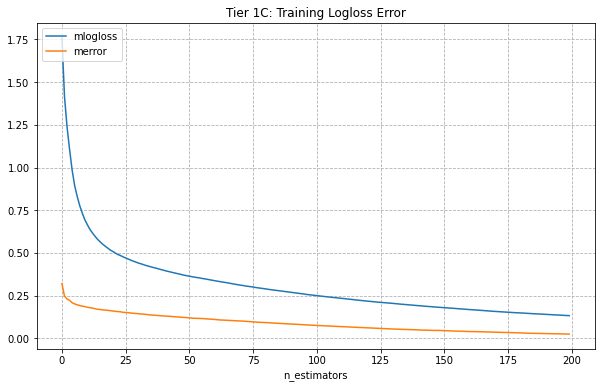

In [102]:
rcParams['figure.figsize'] = 10,6

plt.plot(evals_result.get('validation_0').get('mlogloss'))
plt.plot(evals_result.get('validation_0').get('merror'))
# plt.plot(evals_result.get('validation_1').get('mlogloss'))
plt.title('Tier 1C: Training Logloss Error')
plt.legend(('mlogloss','merror'),loc=2)
plt.xlabel('n_estimators')
# plt.ylabel('mlogloss')
plt.grid(True, linestyle="--")
plt.savefig("Tier1C_mlogloss.png")
plt.show()
# plt.savefig('mlogloss_per_n_estimators.png')

In [103]:
train_score = xgb.score(X_train_train,y_train_train)
print("Tier 1C Training score: ",train_score)

Tier 1C Training score:  0.9747358479428605


In [104]:
best_iteration = xgb.get_booster().best_ntree_limit
y_pred = xgb.predict(X_test, ntree_limit=best_iteration)
print(best_iteration)

200


In [105]:
class_report = classification_report(y_test,y_pred,output_dict= True)
report_df = pd.DataFrame(class_report)
report_df.to_csv('Tier1C_classificationReport.csv')
print(classification_report(y_test,y_pred))


              precision    recall  f1-score   support

        Bath       0.79      0.82      0.80      2200
     Bedroom       0.77      0.91      0.83      2379
     CarPort       0.78      0.51      0.61        89
      Closet       0.61      0.62      0.61       912
      Dining       0.77      0.69      0.73       292
       Entry       0.86      0.89      0.88      1812
      Garage       0.67      0.69      0.68       114
     Kitchen       0.87      0.86      0.87      1363
  LivingRoom       0.78      0.86      0.82      1342
     Outdoor       0.96      0.96      0.96      2354
        Room       0.33      0.09      0.15       615
     Storage       0.69      0.66      0.67       579
     Utility       0.60      0.37      0.46       471

    accuracy                           0.80     14522
   macro avg       0.73      0.69      0.70     14522
weighted avg       0.79      0.80      0.79     14522



['Entry' 'Bedroom' 'LivingRoom' 'Outdoor' 'Bath' 'Closet' 'Storage'
 'Kitchen' 'Room' 'Dining' 'Utility' 'Garage' 'CarPort']
['Entry' 'Bedroom' 'LivingRoom' 'Outdoor' 'Bath' 'Closet' 'Storage'
 'Kitchen' 'Dining' 'Room' 'CarPort' 'Garage' 'Utility']


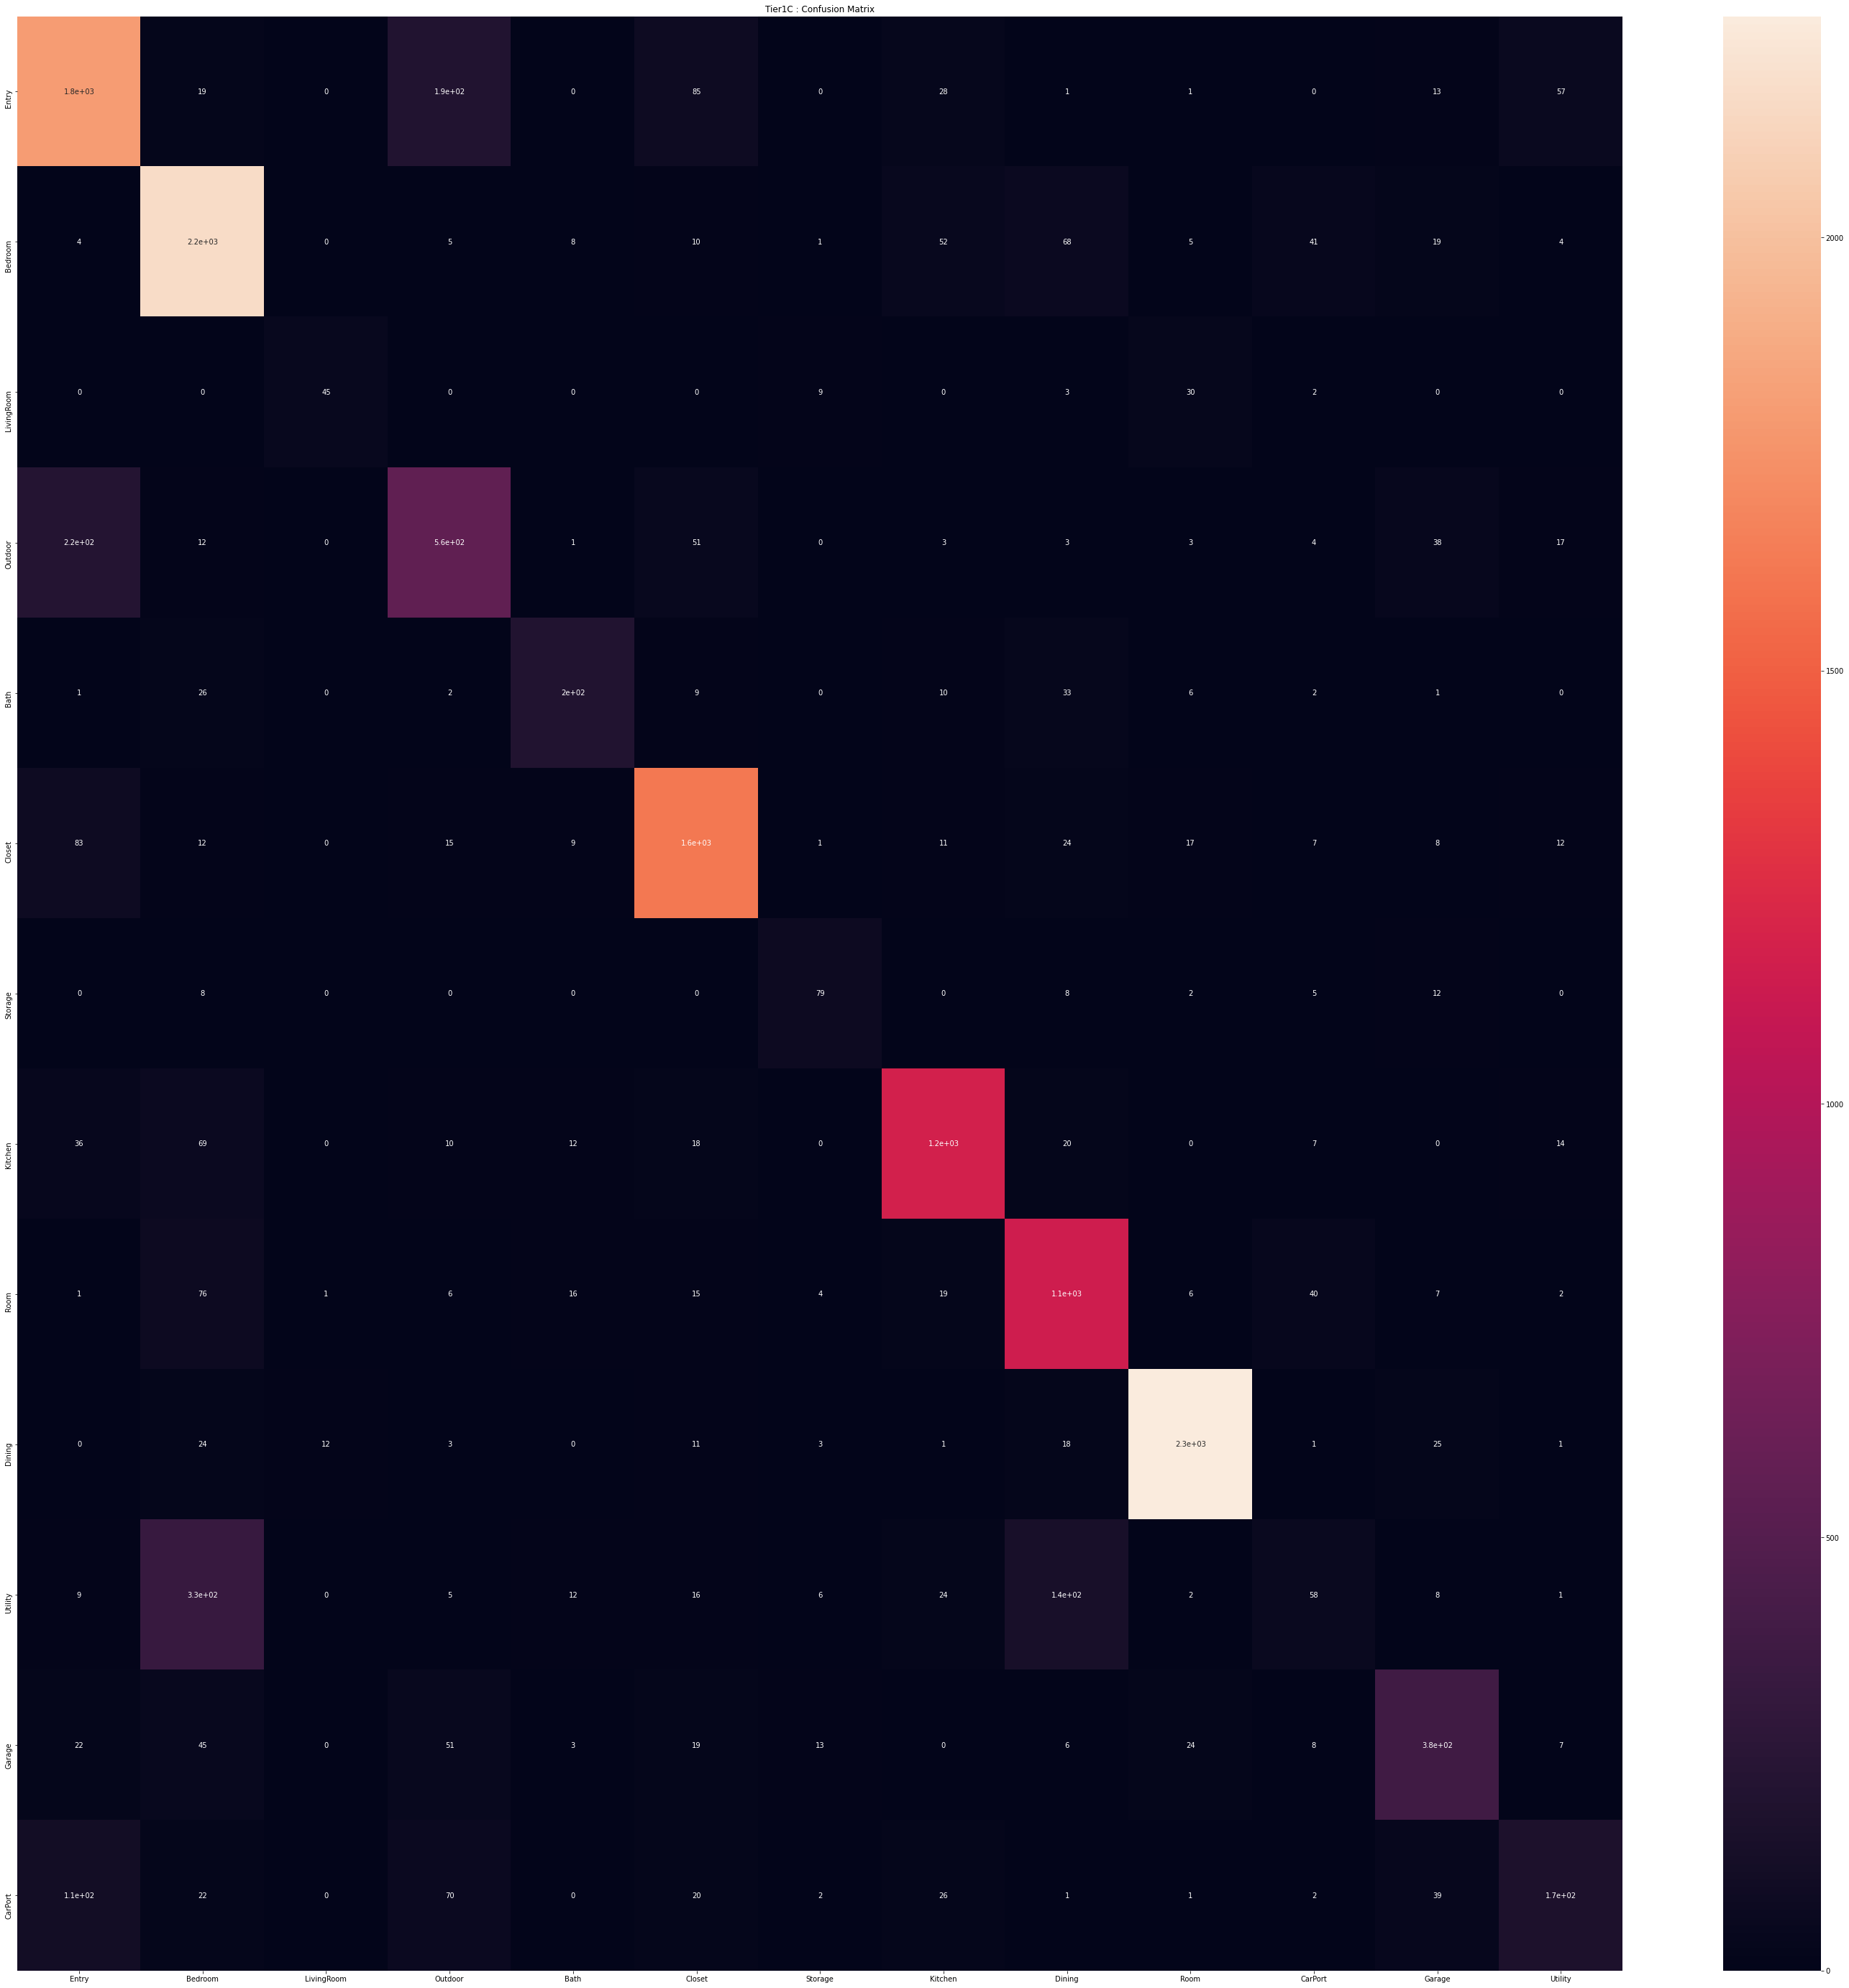

In [106]:
print(pd.Series(y_test).unique())
print(pd.Series(y_pred).unique())
cMat = confusion_matrix(y_test,y_pred)
df_cm = pd.DataFrame(data = cMat , index= pd.Series(y_test).unique() , columns= pd.Series(y_pred).unique())
# df_cm = pd.DataFrame(data = cMat)
# df_cm.head()
plt.figure(figsize= (50,50))
sns.heatmap(df_cm, annot=True)
plt.title('Tier1C : Confusion Matrix')
plt.savefig('Tier1C_CM.png', dpi=100)
plt.show()

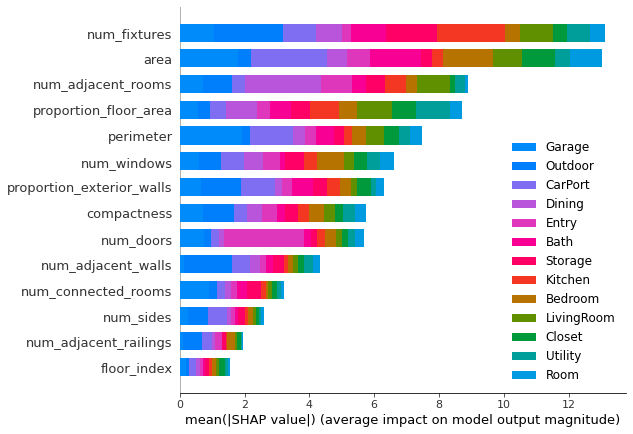

<Figure size 720x432 with 0 Axes>

In [109]:
# Feature importance
shap_values = shap.TreeExplainer(xgb).shap_values(X_train_train)
shap.summary_plot(shap_values, X_train_train, plot_type="bar",class_names=xgb.classes_, title='XGBoost Feature Importance')
plt.savefig('Tier 1c_featureImp.png',dpi=100)
plt.show()

In [116]:
#Grid Search based on best sub dataset (between tier1a, 1b, and 1c based on their classification reports)

#Grid Search

#Reproductability
seed = 342
np.random.seed(seed)
#Define CV strategy:
cv = StratifiedKFold(n_splits=5 , shuffle=True, random_state=seed)
#params_grid
params_grid = {
    'max_depth' : [5,6,7],
    'n_estimators' : [100,150,200,250],
    'learning_rate' : [0.01,0.1]

                }
params_fixed = {
    'objective' : 'multi:softprob',
                }
bst_grid = GridSearchCV(estimator=XGBClassifier(**params_fixed, seed=seed),param_grid=params_grid, cv = cv, scoring='f1_macro')

In [117]:
fit_params = {
        'eval_set':[(X_train_train, y_train_train), (X_train_val, y_train_val)],
        'eval_metric':['mlogloss'],
        'early_stopping_rounds':50
                }
bst_grid.fit(X_train_train,y_train_train,**fit_params)

gloss:0.37668	validation_1-mlogloss:0.63150
[80]	validation_0-mlogloss:0.37526	validation_1-mlogloss:0.63123
[81]	validation_0-mlogloss:0.37346	validation_1-mlogloss:0.63109
[82]	validation_0-mlogloss:0.37120	validation_1-mlogloss:0.63115
[83]	validation_0-mlogloss:0.36931	validation_1-mlogloss:0.63082
[84]	validation_0-mlogloss:0.36706	validation_1-mlogloss:0.63040
[85]	validation_0-mlogloss:0.36494	validation_1-mlogloss:0.63031
[86]	validation_0-mlogloss:0.36267	validation_1-mlogloss:0.63026
[87]	validation_0-mlogloss:0.36093	validation_1-mlogloss:0.63022
[88]	validation_0-mlogloss:0.35935	validation_1-mlogloss:0.63025
[89]	validation_0-mlogloss:0.35750	validation_1-mlogloss:0.63029
[90]	validation_0-mlogloss:0.35613	validation_1-mlogloss:0.63017
[91]	validation_0-mlogloss:0.35448	validation_1-mlogloss:0.63015
[92]	validation_0-mlogloss:0.35253	validation_1-mlogloss:0.63012
[93]	validation_0-mlogloss:0.35067	validation_1-mlogloss:0.63002
[94]	validation_0-mlogloss:0.34916	validation_

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=342, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missi...=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None,
                                     objective='multi:softprob',
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=N

In [118]:
print('Best params:',bst_grid.best_params_)

Best params: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100}


In [119]:
bst_pred = bst_grid.predict(X_test)

In [121]:
class_report = classification_report(y_test,y_pred,output_dict= True)
report_df = pd.DataFrame(class_report)
report_df.to_csv('Tier1C_bestparams_classificationReport.csv')
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

        Bath       0.79      0.82      0.80      2200
     Bedroom       0.77      0.91      0.83      2379
     CarPort       0.78      0.51      0.61        89
      Closet       0.61      0.62      0.61       912
      Dining       0.77      0.69      0.73       292
       Entry       0.86      0.89      0.88      1812
      Garage       0.67      0.69      0.68       114
     Kitchen       0.87      0.86      0.87      1363
  LivingRoom       0.78      0.86      0.82      1342
     Outdoor       0.96      0.96      0.96      2354
        Room       0.33      0.09      0.15       615
     Storage       0.69      0.66      0.67       579
     Utility       0.60      0.37      0.46       471

    accuracy                           0.80     14522
   macro avg       0.73      0.69      0.70     14522
weighted avg       0.79      0.80      0.79     14522



In [178]:
#Clean input data from the target data
# define features and predictions
X = data_tier2.drop([x for x in['path','type','classes','open_to','door_to','contains','type_cleaned','exclude'] if x in data_tier2.columns], axis =1)
y = data_tier2['type_cleaned']
#Split the data into training data, and test data 
X_train , X_test, y_train, y_test = train_test_split(X,y, test_size= 0.3)
X_train_train , X_train_val, y_train_train, y_train_val = train_test_split(X_train,y_train, test_size= 0.5)

In [179]:
#XGB default parameters
model = XGBClassifier(objective='multi:softmax',
                    n_estimators = 100,
                    subsample= 0.9,
                    colsample_bytree = 0.6,
                    learning_rate= 0.1,
                    max_depth= 7)
print(model)

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.6, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=7,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softmax', random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=0.9,
              tree_method=None, validate_parameters=None, verbosity=None)


In [180]:
model.fit(X_train_train,y_train_train,
        eval_set=[(X_train_train, y_train_train), (X_train_val, y_train_val)],
        eval_metric= ['mlogloss','merror'],
        early_stopping_rounds=50,
        verbose=True)

[0]	validation_0-mlogloss:2.53675	validation_0-merror:0.83395	validation_1-mlogloss:2.53675	validation_1-merror:0.83249
[1]	validation_0-mlogloss:2.51179	validation_0-merror:0.83395	validation_1-mlogloss:2.51179	validation_1-merror:0.83249
[2]	validation_0-mlogloss:2.48974	validation_0-merror:0.83395	validation_1-mlogloss:2.48973	validation_1-merror:0.83249
[3]	validation_0-mlogloss:2.46988	validation_0-merror:0.83395	validation_1-mlogloss:2.46987	validation_1-merror:0.83249
[4]	validation_0-mlogloss:2.45223	validation_0-merror:0.83395	validation_1-mlogloss:2.45220	validation_1-merror:0.83249
[5]	validation_0-mlogloss:2.43637	validation_0-merror:0.83395	validation_1-mlogloss:2.43635	validation_1-merror:0.83249
[6]	validation_0-mlogloss:2.42204	validation_0-merror:0.83395	validation_1-mlogloss:2.42202	validation_1-merror:0.83249
[7]	validation_0-mlogloss:2.40915	validation_0-merror:0.83395	validation_1-mlogloss:2.40914	validation_1-merror:0.83249
[8]	validation_0-mlogloss:2.39747	valida

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=0.9,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [173]:
evals_result = model.evals_result()

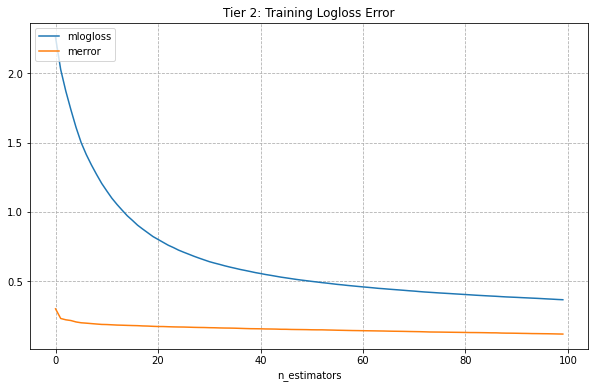

In [174]:
rcParams['figure.figsize'] = 10,6

plt.plot(evals_result.get('validation_0').get('mlogloss'))
plt.plot(evals_result.get('validation_0').get('merror'))
# plt.plot(evals_result.get('validation_1').get('mlogloss'))
plt.title('Tier 2: Training Logloss Error')
plt.legend(('mlogloss','merror'),loc=2)
plt.xlabel('n_estimators')
# plt.ylabel('mlogloss')
plt.grid(True, linestyle="--")
plt.savefig("Tier2_mlogloss.png")
plt.show()
# plt.savefig('mlogloss_per_n_estimators.png')

In [175]:
train_score = model.score(X_train_train,y_train_train)
print("Tier 2 Training score: ",train_score)

Tier 2 Training score:  0.881530015937666


In [176]:
best_iteration = model.get_booster().best_ntree_limit
y_pred = model.predict(X_test, ntree_limit=best_iteration)
print(best_iteration)

100


In [177]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

        Bath       0.79      0.84      0.82      2202
     Bedroom       0.78      0.92      0.84      2417
     CarPort       0.75      0.50      0.60        72
      Closet       0.63      0.66      0.64       924
      Dining       0.73      0.71      0.72       290
       Entry       0.87      0.90      0.89      1758
      Garage       0.65      0.62      0.63       114
     Kitchen       0.85      0.86      0.85      1358
  LivingRoom       0.78      0.87      0.82      1361
     Outdoor       0.95      0.97      0.96      2326
        Room       0.40      0.05      0.09       649
     Storage       0.72      0.65      0.68       595
     Utility       0.63      0.30      0.41       456

    accuracy                           0.81     14522
   macro avg       0.73      0.68      0.69     14522
weighted avg       0.79      0.81      0.79     14522

